In [215]:
pip install scikit-learn

In [216]:
SEED = 123

In [217]:
import numpy as np
import pandas as pd

def generate_data(n_samples):
  np.random.seed(SEED)

  # genera datos de presion
  presion = np.random.randint(70, 180, n_samples)

  # genera datos de colesterol
  colesterol = np.random.randint(120, 250, n_samples)

  # genera datos de indice de masa corporal BMI
  bmi = np.random.uniform(15, 35, n_samples)
  return presion, colesterol, bmi

presion, colesterol, bmi = generate_data(800)
df = pd.DataFrame({'Presion': presion, 'Colesterol': colesterol, 'BMI': bmi})
df.head()

,Presion,Colesterol,BMI
0,179,123,32.996790
1,136,249,21.694050
2,162,229,20.433979
3,168,183,17.714186
4,172,148,31.627539


In [218]:
# estandartizacion de datos
from sklearn.preprocessing import StandardScaler

def estandarizar(df):
  atributos = ['Presion', 'Colesterol', 'BMI']
  original = df[atributos]

  # utilizamos StandardScaler de sklearn
  scaler = StandardScaler()
  data_scaled = scaler.fit_transform(original)
  df_std = pd.DataFrame(data_scaled, columns=atributos)
  return df_std, data_scaled

df_std, data_scaled = estandarizar(df)
df_std.head()

,Presion,Colesterol,BMI
0,1.654061,-1.643702,1.368569
1,0.321671,1.678906,-0.554490
2,1.127303,1.151508,-0.768880
3,1.313217,-0.061508,-1.231628
4,1.437161,-0.984454,1.135604


In [219]:
def calculate_risk(p, c, bmi):
    return sum([
        (p < 100) + (121 <= p <= 140) + 2 * (p > 140),
        (180 <= c <= 200) + 2 * (c > 200),
        (25 <= bmi <= 30) + 2 * (bmi > 30)
    ])

df['Riesgo'] = df.apply(lambda row: calculate_risk(row['Presion'], row['Colesterol'], row['BMI']), axis=1)
df['Riesgo'] = (df['Riesgo'] >= 3).astype(int)
df.head()

,Presion,Colesterol,BMI,Riesgo
0,179,123,32.996790,1
1,136,249,21.694050,1
2,162,229,20.433979,1
3,168,183,17.714186,1
4,172,148,31.627539,1


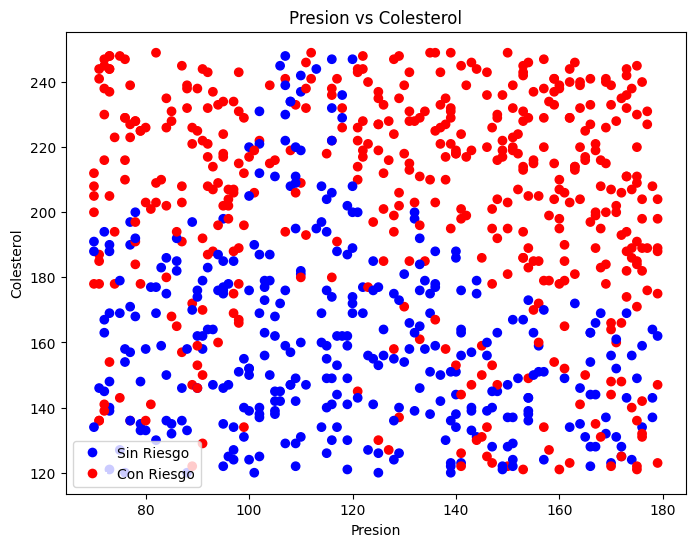

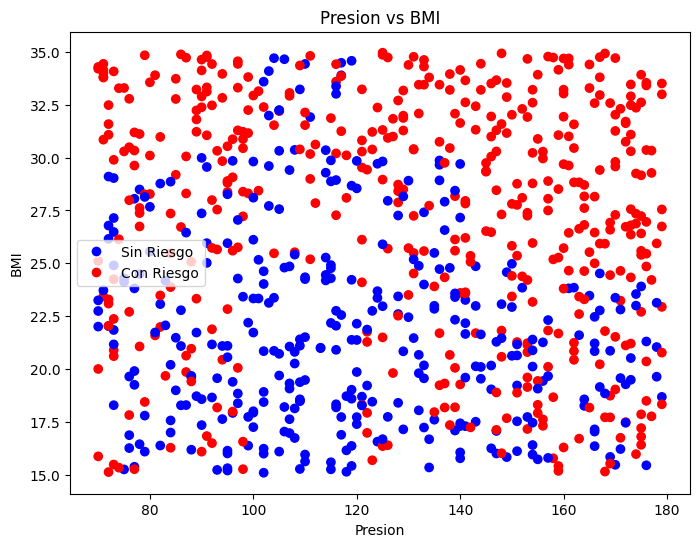

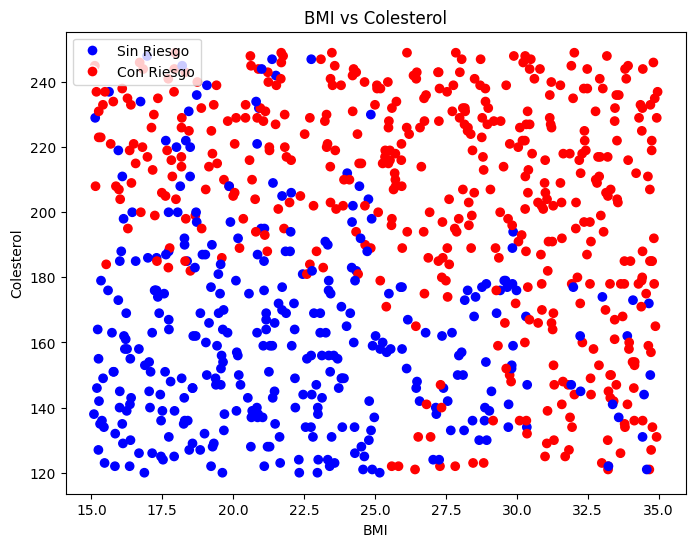

In [220]:
import matplotlib.pyplot as plt

colors = {0: 'blue', 1: 'red'}

# pares de atributos a comparar
feature_pairs = [('Presion', 'Colesterol'), ('Presion', 'BMI'), ('BMI', 'Colesterol')]

# dibuja graficos de cada par, incluyendo problemas potenciales
for x_feature, y_feature in feature_pairs:
  plt.figure(figsize=(8, 6))
  plt.scatter(df[x_feature], df[y_feature], c=df['Riesgo'].map(colors))
  plt.xlabel(x_feature)
  plt.ylabel(y_feature)
  plt.title(f'{x_feature} vs {y_feature}')
  plt.legend(handles=[
      plt.Line2D([], [], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Sin Riesgo'),
      plt.Line2D([], [], marker='o', color='w', markerfacecolor='red', markersize=8, label='Con Riesgo')
  ])
  plt.show()

In [222]:
# separar datos normalizados en entrenamiento y evaluacion
from sklearn.model_selection import train_test_split

y = df['Riesgo']

# utilizaremos para el entrenamiento los datos estandartizados
X_train, X_test, y_train, y_test = train_test_split(data_scaled, y, test_size=0.25, random_state=SEED)

In [223]:
from sklearn.linear_model import LogisticRegression

# entrenar model
model = LogisticRegression()
model.fit(X_train, y_train)

# summary de model
print(model.coef_)
print(model.intercept_)

[[0.93181836 2.14874102 1.81489646]]
[0.72737122]


In [224]:
from sklearn.metrics import accuracy_score

# predicciones
y_pred = model.predict(X_test)
print(y_pred[:10])

# precision de predicciones
accuracy = accuracy_score(y_test, y_pred)
print(f"Precision: {accuracy}")

[1 1 1 0 0 0 1 0 0 0]
Precision: 0.835


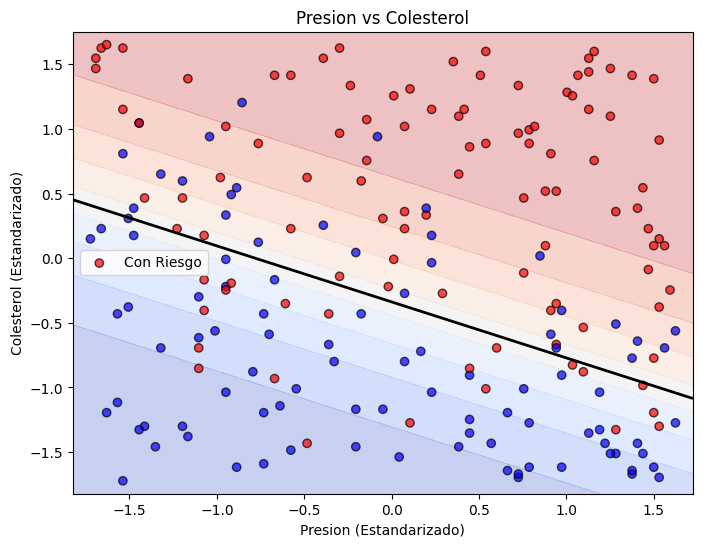

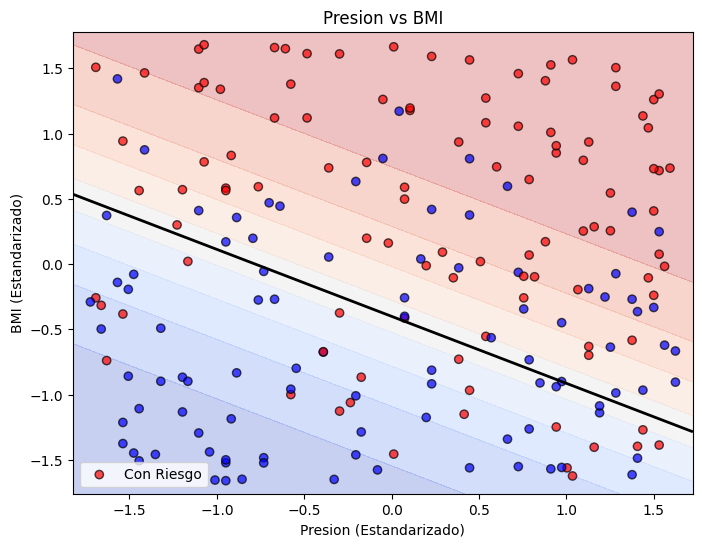

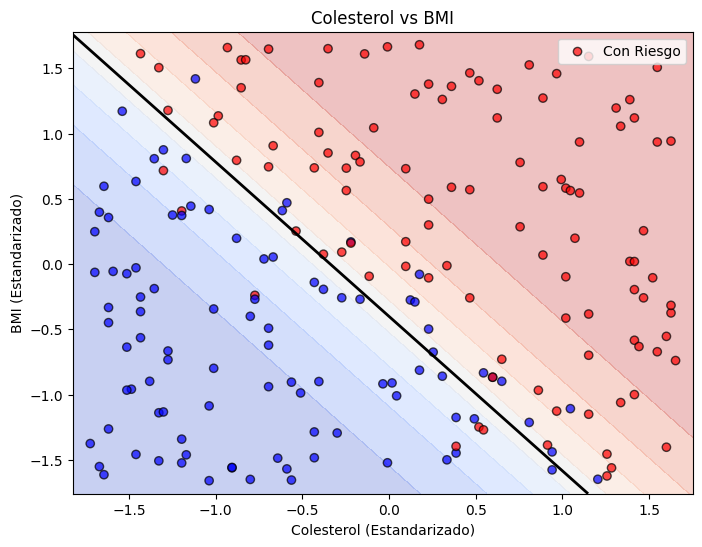

In [225]:
import numpy as np
import matplotlib.pyplot as plt

def plot_regression_logistica(model, X_test, y_pred):
  # pares de atributos a graficar
  feature_pairs = [
    (0, "Presion", 1, "Colesterol"),
    (0, "Presion", 2, "BMI"),
    (1, "Colesterol", 2, "BMI")
  ]

  for x_idx, x_label, y_idx, y_label in feature_pairs:
    plt.figure(figsize=(8, 6))

    # creamos un grid
    x_min, x_max = X_test[:, x_idx].min() - 0.1, X_test[:, x_idx].max() + 0.1
    y_min, y_max = X_test[:, y_idx].min() - 0.1, X_test[:, y_idx].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

    # para cada pareja, ignoramos el atributo tercero, lo ponemos a 0 (mean value)
    grid = np.zeros((xx.ravel().shape[0], X_test.shape[1]))
    grid[:, x_idx] = xx.ravel()
    grid[:, y_idx] = yy.ravel()

    # prediccion de probabilidades
    probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)

    # curva de regression para separar clases (con regiones colorados)
    plt.contourf(xx, yy, probs, levels=np.linspace(0, 1, 10), cmap='coolwarm', alpha=0.3)
    plt.contour(xx, yy, probs, levels=[0.5], linewidths=2, colors='black')

    # resultados predichos actuales
    plt.scatter(X_test[:, x_idx], X_test[:, y_idx], c=y_pred, cmap='bwr', edgecolor='k', alpha=0.7)

    plt.xlabel(f'{x_label} (Estandarizado)')
    plt.ylabel(f'{y_label} (Estandarizado)')
    plt.title(f'{x_label} vs {y_label}')
    plt.legend(['Con Riesgo'])
    plt.show()

plot_regression_logistica(model, X_test, y_pred)

Entrenamos con el conjunto de 500 personas

In [226]:
# generamos nuevo dataset
presion, colesterol, bmi = generate_data(n_samples=500)

df_2 = pd.DataFrame({'Presion': presion, 'Colesterol': colesterol, 'BMI': bmi})
df_2.head()

,Presion,Colesterol,BMI
0,179,142,18.173583
1,136,166,23.398463
2,162,169,19.924858
3,168,241,19.106995
4,172,128,28.696517


In [227]:
# estandartizamos nuevo dataset
df_2_std, data_2_scaled = estandarizar(df_2)
df_2_std.head()

,Presion,Colesterol,BMI
0,1.566001,-1.059122,-1.069189
1,0.268693,-0.431959,-0.180184
2,1.053112,-0.353563,-0.771212
3,1.234132,1.527927,-0.910370
4,1.354811,-1.424967,0.721271


In [228]:
# calculamos riesgo de problemas vasculares para el nuevo dataset
df_2['Riesgo'] = df_2.apply(lambda row: calculate_risk(row['Presion'], row['Colesterol'], row['BMI']), axis=1)
df_2['Riesgo'] = (df_2['Riesgo'] >= 3).astype(int)
df_2.head()

,Presion,Colesterol,BMI,Riesgo
0,179,142,18.173583,0
1,136,166,23.398463,0
2,162,169,19.924858,0
3,168,241,19.106995,1
4,172,128,28.696517,1


In [229]:
# separar datos nuevos normalizados en entrenamiento y evaluacion
from sklearn.model_selection import train_test_split

y = df_2['Riesgo']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(data_2_scaled, y, test_size=0.25, random_state=SEED)

In [230]:
from sklearn.linear_model import LogisticRegression

# entrenar model nuevo
model_2 = LogisticRegression()
model_2.fit(X_train_2, y_train_2)

# summary de model
print(model_2.coef_)
print(model_2.intercept_)

[[0.86425158 2.01018651 1.82323002]]
[0.46357668]


In [231]:
from sklearn.metrics import accuracy_score

# predicciones
y_pred_2 = model_2.predict(X_test_2)
print(y_pred_2[:10])

# precision de predicciones
accuracy = accuracy_score(y_test_2, y_pred_2)
print(f"Accuracy: {accuracy}")

[0 1 1 1 0 1 1 0 1 0]
Accuracy: 0.832


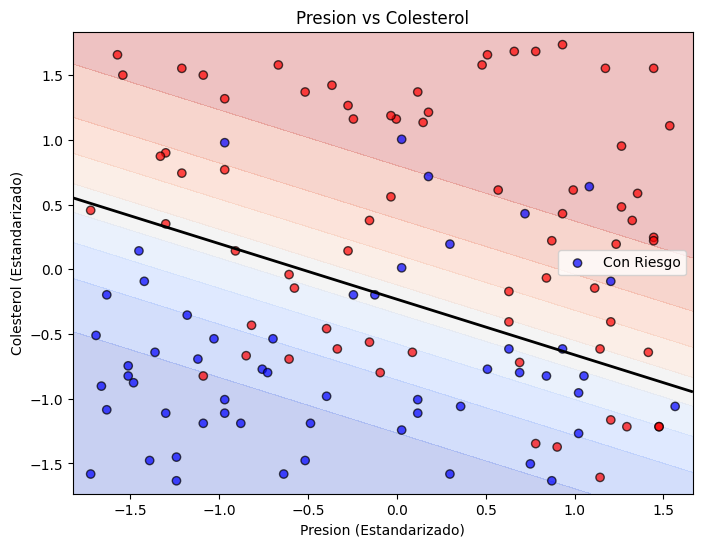

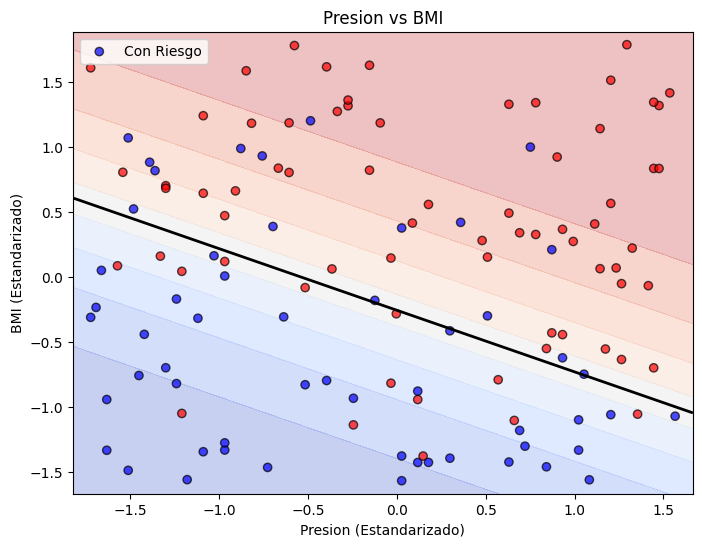

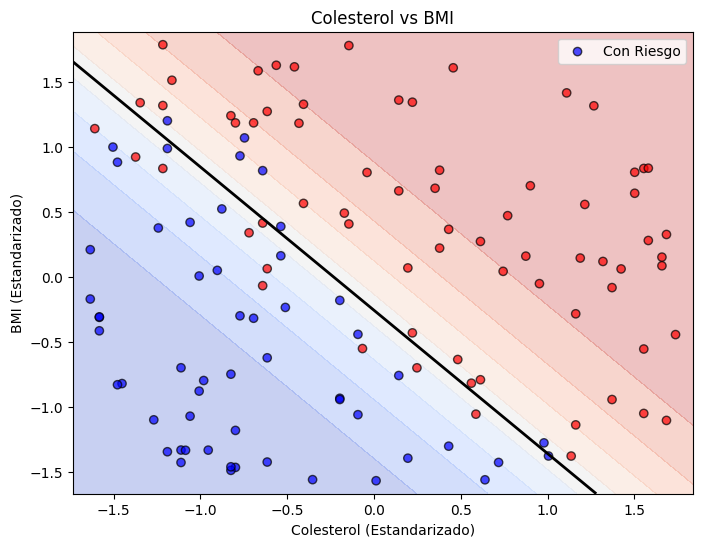

In [232]:
plot_regression_logistica(model_2, X_test_2, y_pred_2)